In [162]:
import nltk
import pandas as pd
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords
import seaborn as sns
import string

In [3]:
train = pd.read_csv('train.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
train.shape

(7613, 5)

In [4]:
test = pd.read_csv('test.csv')
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [132]:
test['keyword'].isnull().sum()

26

In [6]:
#create different set for True and False train sets
train_true = train[train['target']==1]
train_true.shape

(3271, 5)

In [7]:
train_false = train[train['target']==0]
train_false.shape

(4342, 5)

In [45]:
#keywords used in true cases
keyword_true = train_true['keyword'].value_counts()
keyword_true

wreckage       39
outbreak       39
derailment     39
typhoon        37
oil%20spill    37
               ..
epicentre       1
ruin            1
electrocute     1
blazing         1
body%20bags     1
Name: keyword, Length: 220, dtype: int64

In [47]:
#keywords used in false cases
keyword_false = train_false['keyword'].value_counts()
keyword_false

body%20bags          40
armageddon           37
harm                 37
deluge               36
ruin                 36
                     ..
suicide%20bombing     1
oil%20spill           1
suicide%20bomber      1
typhoon               1
outbreak              1
Name: keyword, Length: 218, dtype: int64

In [13]:
train_true['keyword'].isnull().sum()

42

In [131]:
train_false['keyword'].value_counts()

body%20bags          40
armageddon           37
harm                 37
deluge               36
ruin                 36
                     ..
suicide%20bombing     1
oil%20spill           1
suicide%20bomber      1
typhoon               1
outbreak              1
Name: keyword, Length: 218, dtype: int64

In [16]:
train_false['keyword'].isnull().sum()

19

In [17]:
train_true['location'].value_counts()

USA                     67
United States           27
Nigeria                 22
India                   20
Mumbai                  19
                        ..
ss                       1
Nashville, Tennessee     1
Halton, Ontario          1
PDX                      1
San Mateo County, CA     1
Name: location, Length: 1513, dtype: int64

In [18]:
train_false['location'].value_counts()

New York                         55
USA                              37
London                           29
United States                    23
Los Angeles, CA                  18
                                 ..
Basking Ridge, NJ                 1
East London.                      1
Dayton, OH                        1
Extraterrestrial Highway          1
?? Made in the Philippines ??     1
Name: location, Length: 2142, dtype: int64

In [27]:
train_true['location'].isnull().sum()

1075

In [28]:
train_false['location'].isnull().sum()

1458

In [21]:
df_all = pd.concat([train,test],axis=0)
df_all.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0


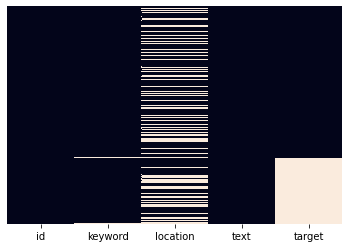

In [23]:
sns.heatmap(df_all.isnull(),yticklabels=False,cbar=False)

In [24]:
df_all.isnull().sum()

id             0
keyword       87
location    3638
text           0
target      3263
dtype: int64

In [25]:
test['location'].value_counts()

New York                      38
USA                           37
Worldwide                     16
United States                 15
London                        13
                              ..
Citizen of the World           1
centre of attention            1
Niger State                    1
Franklinton - BR - Houston     1
West Coast, Canada             1
Name: location, Length: 1602, dtype: int64

In [26]:
test['location'].isnull().sum()

1105

In [29]:
#new feature length of text
df_all['text_len'] = df_all['text'].apply(lambda x : len(x))
df_all['text_len'].head()

0     69
1     38
2    133
3     65
4     88
Name: text_len, dtype: int64

In [32]:
def capital_letters_count(sentence):
    sum1 = 0
    for c in sentence:
        if c.isupper():
            sum1 = sum1 + 1
    return sum1

In [33]:
# number of capital letters
df_all['capital_letters'] = df_all['text'].apply(lambda x : capital_letters_count(x))
df_all['capital_letters'].head()

0    10
1     5
2     2
3     1
4     3
Name: capital_letters, dtype: int64

In [34]:
df_all['capital_letters'].value_counts()

1      868
2      770
3      700
4      700
6      675
      ... 
98       1
78       1
118      1
87       1
97       1
Name: capital_letters, Length: 96, dtype: int64

In [39]:
string.punctuation


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [40]:
def count_punctuation(sentence):
    sum2 = 0 
    for c in sentence:
        if c in string.punctuation:
            sum2 = sum2 + 1
    return sum2
            
        

In [42]:
#testing the function
sen = 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'
sen2 = 'What a goooooooaaaaaal!!!!!!'
s = count_punctuation(sen2)
s

6

In [43]:
df_all['punctuations'] = df_all.text.apply(lambda x : count_punctuation(x))
df_all['punctuations'].head()

0    1
1    1
2    3
3    2
4    2
Name: punctuations, dtype: int64

In [56]:
df_all['location'].dtypes

dtype('O')

In [59]:
df_all['location_text'] = df_all['location'].astype(str) + ' ' + df_all['text'].astype(str)
df_all['location_text'].head()

0    nan Our Deeds are the Reason of this #earthqua...
1           nan Forest fire near La Ronge Sask. Canada
2    nan All residents asked to 'shelter in place' ...
3    nan 13,000 people receive #wildfires evacuatio...
4    nan Just got sent this photo from Ruby #Alaska...
Name: location_text, dtype: object

In [60]:
#function to check if a HTTP link exists in text


In [61]:
df_all.head()

,id,keyword,location,text,target,text_len,capital_letters,punctuations,location_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,69,10,1,nan Our Deeds are the Reason of this #earthqua...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,38,5,1,nan Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,133,2,3,nan All residents asked to 'shelter in place' ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,65,1,2,"nan 13,000 people receive #wildfires evacuatio..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,88,3,2,nan Just got sent this photo from Ruby #Alaska...


In [112]:
chachedWords = stopwords.words('english')
chachedWords.append('nan')
chachedWords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [116]:
#removing punctuation and stop words function
def clean_text(sentence):
    ps = nltk.PorterStemmer()
    #nltk.download("stopwords")
    chachedWords = stopwords.words('english')
    chachedWords.append('nan')
    temp = ""
    return_sentence = ""
    sentence = sentence.lower()
    for c in sentence:
        if c not in string.punctuation:
            temp = temp+c
    temp_arr = temp.split()
    for word in temp_arr:
        if word not in chachedWords:
            word = ps.stem(word)
            return_sentence = return_sentence + word + " "
    return_sentence = return_sentence.strip()
    return return_sentence

In [117]:
nltk.download("stopwords")
nan = ['nan']
df_all['clean_text'] = df_all.location_text.apply(lambda x: clean_text(x))
df_all['clean_text'].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\i318517\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0            deed reason earthquak may allah forgiv us
1                 forest fire near la rong sask canada
2    resid ask shelter place notifi offic evacu she...
3    13000 peopl receiv wildfir evacu order california
4    got sent photo rubi alaska smoke wildfir pour ...
Name: clean_text, dtype: object

In [148]:
#only remove puntuation
def remove_punctuation(sentence):
    ps = nltk.PorterStemmer()
    null_value = ['nan']
    temp = ""
    return_sentence = ""
    sentence = sentence.lower()
    for c in sentence:
        if c not in string.punctuation:
            temp = temp+c
    temp_arr = temp.split()
    for word in temp_arr:
        if word not in null_value:
            return_sentence = return_sentence + word + " "
    return_sentence = return_sentence.strip()
    return return_sentence

In [149]:
df_all['remove_punctuations'] = df_all.text.apply(lambda x : remove_punctuation(x))
df_all['remove_punctuations'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    13000 people receive wildfires evacuation orde...
4    just got sent this photo from ruby alaska as s...
Name: remove_punctuations, dtype: object

In [150]:
df_all.describe()


,id,target,text_len,capital_letters,punctuations
count,10876.000000,7613.00000,10876.000000,10876.000000,10876.000000
mean,5437.500000,0.42966,101.358680,10.041743,6.872839
std,3139.775098,0.49506,33.840687,10.746684,4.572513
min,0.000000,0.00000,5.000000,0.000000,0.000000
25%,2718.750000,0.00000,78.000000,3.000000,3.000000
50%,5437.500000,0.00000,108.000000,8.000000,6.000000
75%,8156.250000,1.00000,134.000000,13.000000,10.000000
max,10875.000000,1.00000,157.000000,118.000000,61.000000


In [151]:
df_all_feature = df_all.drop(['location','text','location_text'],axis=1)
df_all_feature.head()

,id,keyword,target,text_len,capital_letters,punctuations,clean_text,remove_punctuations
0,1,NaN,1.0,69,10,1,deed reason earthquak may allah forgiv us,our deeds are the reason of this earthquake ma...
1,4,NaN,1.0,38,5,1,forest fire near la rong sask canada,forest fire near la ronge sask canada
2,5,NaN,1.0,133,2,3,resid ask shelter place notifi offic evacu she...,all residents asked to shelter in place are be...
3,6,NaN,1.0,65,1,2,13000 peopl receiv wildfir evacu order california,13000 people receive wildfires evacuation orde...
4,7,NaN,1.0,88,3,2,got sent photo rubi alaska smoke wildfir pour ...,just got sent this photo from ruby alaska as s...


In [152]:
pd.set_option('display.max_rows', 221)

In [153]:
df_all_feature['keyword'].value_counts()

suicide%20bomb           50
catastrophic             50
harm                     50
rubble                   50
wounds                   50
sirens                   50
hazard                   50
ambulance                50
rainstorm                50
debris                   50
injury                   50
casualty                 50
burning%20buildings      50
crash                    50
buildings%20on%20fire    50
devastated               50
buildings%20burning      50
wrecked                  50
survived                 50
disaster                 50
electrocuted             50
cyclone                  50
blood                    50
tragedy                  50
attack                   50
mayhem                   50
arsonist                 50
burned                   50
heat%20wave              50
loud%20bang              50
explode                  50
aftershock               50
detonate                 50
forest%20fires           50
airplane%20accident      50
deaths              

In [190]:
keywords = df_all_feature['keyword'].unique()
keywords = np.delete(keywords,0)
keywords

array(['ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'derailed

In [195]:
df_all_feature['keyword'] = df_all['keyword']

In [224]:
all_keywords = []
def fill_missing_keyword_values(sentence):
    temp = sentence.split()
    return_word = np.nan
    for word in temp:
        if word in keywords:
            return_word = word
            break
    all_keywords.append(return_word)
    print(return_word)
    return return_word
            
    

In [226]:
df_all_feature['keyword'].isnull().sum()

87

In [227]:
all_keywords

['earthquake',
 'fire',
 'evacuation',
 'evacuation',
 'smoke',
 'fire',
 'flood',
 'fire',
 'emergency',
 'tornado',
 nan,
 'flooding',
 'flooding',
 'flood',
 'damage',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 'ablaze',
 nan,
 'ablaze',
 'ablaze',
 'ablaze',
 'ablaze',
 'ablaze',
 'ablaze',
 'ablaze',
 nan,
 'ablaze',
 'ablaze',
 'ablaze',
 'ablaze',
 nan,
 'burned',
 'ablaze',
 nan,
 nan,
 'ablaze',
 'ablaze',
 'police',
 'police',
 nan,
 'ablaze',
 'ablaze',
 'ablaze',
 'ablaze',
 'burned',
 'ablaze',
 'ablaze',
 'ablaze',
 'ablaze',
 'ablaze',
 'fire',
 'ablaze',
 'accident',
 'accident',
 'accident',
 'accident',
 'accident',
 'accident',
 'accident',
 'accident',
 'accident',
 'accident',
 'accident',
 'accident',
 nan,
 'accident',
 'accident',
 'accident',
 nan,
 'accident',
 'accident',
 'accident',
 'accident',
 'accident',
 'accident',
 'accident',
 'accident',
 'accident',
 'accident',
 'accident',
 nan,
 'accident',


In [229]:
df_all_feature['all_keywords'] = all_keywords
df_all_feature.isnull().sum()

id                        0
keyword                  87
target                 3263
text_len                  0
capital_letters           0
punctuations              0
clean_text                0
remove_punctuations       0
all_keywords           1663
dtype: int64

In [238]:
df_all_feature['temp_key'] = df_all_feature['keyword']
df_all_feature.isnull().sum()

id                        0
keyword                  87
target                 3263
text_len                  0
capital_letters           0
punctuations              0
clean_text                0
remove_punctuations       0
all_keywords           1663
temp_key                 87
dtype: int64

In [243]:
df_all_feature['temp_key'] = df_all_feature.apply(lambda row: fill_missing_keyword_values(row['remove_punctuations']) if np.isnan(row['temp_key']) else row['temp_key'])
df_all_feature.isnull().sum()

KeyError: 'temp_key'

In [233]:
df_all_feature['all_keywords'].head()

0    earthquake
1          fire
2    evacuation
3    evacuation
4         smoke
Name: all_keywords, dtype: object

In [234]:
df_all_feature['temp_key'].head()

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: temp_key, dtype: object

In [245]:
df_new = df_all_feature.drop(['temp_key','all_keywords','remove_punctuations'],axis=1)
df_new.head()

,id,keyword,target,text_len,capital_letters,punctuations,clean_text
0,1,NaN,1.0,69,10,1,deed reason earthquak may allah forgiv us
1,4,NaN,1.0,38,5,1,forest fire near la rong sask canada
2,5,NaN,1.0,133,2,3,resid ask shelter place notifi offic evacu she...
3,6,NaN,1.0,65,1,2,13000 peopl receiv wildfir evacu order california
4,7,NaN,1.0,88,3,2,got sent photo rubi alaska smoke wildfir pour ...


In [264]:
#scale data using standard scaler
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
df_new [['text_len','capital_letters','punctuations']]= scale.fit_transform(df_new[['text_len','capital_letters','punctuations']])
df_new.head()

,id,keyword,target,text_len,capital_letters,punctuations,clean_text
0,1,NaN,1.0,-0.956250,-0.003884,-1.284438,deed reason earthquak may allah forgiv us
1,4,NaN,1.0,-1.872349,-0.469166,-1.284438,forest fire near la rong sask canada
2,5,NaN,1.0,0.935051,-0.748334,-0.847022,resid ask shelter place notifi offic evacu she...
3,6,NaN,1.0,-1.074457,-0.841391,-1.065730,13000 peopl receiv wildfir evacu order california
4,7,NaN,1.0,-0.394770,-0.655278,-1.065730,got sent photo rubi alaska smoke wildfir pour ...


In [281]:
#Encoding data using Count Venctorizer
count_vect = CountVectorizer()
X_count = count_vect.fit_transform(df_new['clean_text'])
df_new.reset_index(drop=True, inplace=True)
X_count_feat = pd.concat([df_new['target'],df_new['text_len'],df_new['capital_letters'],df_new['punctuations'],
                           pd.DataFrame(X_count.toarray())], axis=1)
#X_count_feat = pd.DataFrame(X_count.toarray())
X_count_feat.head()

,target,text_len,capital_letters,punctuations,0,1,2,3,4,5,...,27464,27465,27466,27467,27468,27469,27470,27471,27472,27473
0,1.0,-0.956250,-0.003884,-1.284438,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,-1.872349,-0.469166,-1.284438,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0.935051,-0.748334,-0.847022,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,-1.074457,-0.841391,-1.065730,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,-0.394770,-0.655278,-1.065730,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [266]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [282]:
train_new = X_count_feat[X_count_feat.target.notnull()]
train_new.shape

(7613, 27478)

In [283]:
test_new = X_count_feat[X_count_feat.target.isnull()]
test_new.shape

(3263, 27478)

In [284]:
x_train = train_new.drop(['target'],axis=1)
y_train = train_new['target']

In [285]:
x_test = test_new.drop(['target'],axis=1)
x_test.shape

(3263, 27477)

In [277]:
#Naive Bayes
gnb = GaussianNB()
cv = cross_val_score(gnb,x_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.61785949 0.54103743 0.56992777 0.57095926 0.55978975]
0.5719147405140452


In [278]:
#Logistic Regression
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,x_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.70321733 0.63624425 0.6690742  0.68199737 0.74770039]
0.6876467101465656


In [286]:
#decision tree classifier
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt,x_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.6651346  0.56795798 0.56861458 0.62943495 0.69448095]
0.6251246114117047


In [287]:
#K nearest neighbour
knn = KNeighborsClassifier()
cv = cross_val_score(knn,x_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.60472751 0.62967827 0.59553513 0.63731932 0.67871222]
0.6291944887114184


In [280]:
#random forest
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,x_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.69862114 0.62836507 0.68745896 0.6478318  0.75886991]
0.6842293764554535


In [290]:
#xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state =1)
cv = cross_val_score(xgb,x_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.69271175 0.59816152 0.60078792 0.62943495 0.72207622]
0.6486344729047294


In [ ]:
svc = SVC(probability = True)
cv = cross_val_score(svc,x_train,y_train,cv=5)
print(cv)
print(cv.mean())

In [292]:
LRclassifier = LogisticRegression(max_iter = 2000)
LRclassifier.fit(x_train,y_train)

LogisticRegression(max_iter=2000)

In [293]:
import pickle
filename = 'finalised_model.pkl'
pickle.dump(LRclassifier,open(filename,'wb'))

In [295]:
y_pred=LRclassifier.predict(x_test)

In [296]:
y_pred


array([1., 1., 1., ..., 1., 1., 0.])

In [297]:
#LR submission without HPO
pred = pd.DataFrame(y_pred)
sub_fr = pd.read_csv('sample_submission.csv')
datasets = pd.concat([sub_fr['id'],pred],axis=1)
datasets.columns = ['id','target']
datasets.to_csv('sample_submission.csv',index=False) 